# Bitcoin Transaction Analysis - Bull Phase in 2011 - 2013
- by Malik Sogukoglu

## References
- Inspiration for Workflow structure: 
 - https://www.bmc.com/blogs/python-spark-k-means-example/
 - https://www.kaggle.com/statsfromarg/btc-data-exploratory-analysis-with-txn
- K-means clustering in Spark
 - https://spark.apache.org/docs/latest/ml-clustering.html
 - https://towardsdatascience.com/k-means-clustering-using-pyspark-on-big-data-6214beacdc8b
- Sampling:
 - https://stackoverflow.com/questions/24806084/sampling-a-large-distributed-data-set-using-pyspark-spark
- Filter pushdown: 
 - https://engineering.dynatrace.com/blog/optimizing-spark-queries-with-filter-pushdown/
 - https://towardsdatascience.com/predicate-vs-projection-pushdown-in-spark-3-ac24c4d11855
- Read data: 
 - Reading several files: https://stackoverflow.com/questions/49898742/pandas-reading-csv-files-with-partial-wildcard
 - Correct processing of the date value as part of filtering (1): https://stackoverflow.com/questions/19480028/attributeerror-datetime-module-has-no-attribute-strptime 
 - Correct processing of the date value as part of filtering(2) :https://stackoverflow.com/questions/19801727/convert-datetime-to-unix-timestamp-and-convert-it-back-in-python
- In-memory data processing:
 - https://phoenixnap.com/kb/hadoop-vs-spark 
- Disable infer schema
 - https://stackoverflow.com/questions/56927329/spark-option-inferschema-vs-header-true/56933052

## Set up environment

In [1]:
!pip install pyspark



In [1]:
from pyspark.sql import SparkSession


In [2]:
import glob

In [4]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, TimestampType

In [5]:
from pyspark.sql import functions as F

## Define data schema

In [6]:
schema = StructType([ \
    StructField("value",IntegerType(),True), \
    StructField("fee",IntegerType(),True), \
    StructField("timestamp_in_unix_seconds",IntegerType(),True), \
  ])

## Set configurations
- Amount of **executors is set to 4**, enabling **parallel processing**
- **Executors** are allocated with **8GB RAM**
- **Spark driver** is allocated with **16GB RAM**
- **Filter pushdown** is enabled, to prevent not requested data to be loaded into memory

In [10]:
from pyspark.conf import SparkConf


config = SparkConf().setAll([ \
    ('spark.executor.memory', '8g'), \
    ('spark.executor.instances', '4'), \
    ('spark.driver.memory','16g'), \
    ("spark.sql.parquet.filterPushdown", "true"), \
    ("spark.hadoop.parquet.filter.stats.enabled", "true"), \
    ("spark.sql.optimizer.nestedSchemaPruning.enabled", "true"), \
    ("spark.sql.optimizer.dynamicPartitionPruning.enabled", "true")])

## Open Spark session

In [11]:
print(config.setMaster("local").setAppName("Clustering using K-Means"))

print(config.get("spark.master"))

print(config.get("spark.app.name"))


local
Clustering using K-Means


In [12]:
import time

from datetime import datetime
spark = SparkSession.builder.appName("Clustering using K-Means") \
    .config(conf=config) \
    .getOrCreate() \
#    .option("failOnDataLoss", False)
#spark

In [13]:
spark

### Check applied configurations

In [14]:
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.executor.instances', '4'),
 ('spark.sql.parquet.filterPushdown', 'true'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.optimizer.dynamicPartitionPruning.enabled', 'true'),
 ('spark.driver.memory', '16g'),
 ('spark.driver.port', '51627'),
 ('spark.app.startTime', '1637776197398'),
 ('spark.sql.optimizer.nestedSchemaPruning.enabled', 'true'),
 ('spark.sql.warehouse.dir', 'file:/D:/Bitcoin%20analysis/spark-warehouse'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.memory', '8g'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1637776201013'),
 ('spark.hadoop.parquet.filter.stats.enabled', 'true'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Clustering using K-Means'),
 ('spark.driver.host', '10.0.7.40')]

## Indicate data to be read

In [15]:
import glob
import os
BITCOIN_PATHS = sorted(glob.glob(os.path.join("D:\\Downloads\\bitcoin_data_filtered\\", "*")))
BITCOIN_PATHS

['D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000000',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000001',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000002',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000003',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000004',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000005',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000006',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000007',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000008',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000009',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000010',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000011',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000012',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000013',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000014',
 'D:\\Downloads\\bitcoin_data_filtered\\bitcoin000000000015',
 'D:\\Do

## Load Bitcoin data into Spark
- Select the columns **Value** and **Fee**.
- Filter by timestamp (**timestamp_in_unix_time**).
- Load data into cache (with persist()) to avoid having to reload data for different analyses

In [16]:
data_customer=spark.read.csv(BITCOIN_PATHS, header=True, schema=schema) \
    .select("value","fee") \
    .filter((F.col('timestamp_in_unix_seconds') >= int(time.mktime(datetime.strptime('2011-11-19', '%Y-%m-%d').timetuple()))) & (F.col('timestamp_in_unix_seconds') <= int(time.mktime(datetime.strptime('2013-10-04', '%Y-%m-%d').timetuple())))) \
    .persist()
data_customer.printSchema()

root
 |-- value: integer (nullable = true)
 |-- fee: integer (nullable = true)



## Show explanation of data loading plan
Here, Spark shows how it will approach the data loading process, defined above

In [17]:
data_customer.explain()

== Physical Plan ==
*(1) ColumnarToRow
+- InMemoryTableScan [value#0, fee#1]
      +- InMemoryRelation [value#0, fee#1], StorageLevel(disk, memory, deserialized, 1 replicas)
            +- *(1) Project [value#0, fee#1]
               +- *(1) Filter ((isnotnull(timestamp_in_unix_seconds#2) AND (timestamp_in_unix_seconds#2 >= 1321657200)) AND (timestamp_in_unix_seconds#2 <= 1380837600))
                  +- FileScan csv [value#0,fee#1,timestamp_in_unix_seconds#2] Batched: false, DataFilters: [isnotnull(timestamp_in_unix_seconds#2), (timestamp_in_unix_seconds#2 >= 1321657200), (timestamp_..., Format: CSV, Location: InMemoryFileIndex[file:/D:/Downloads/bitcoin_data_filtered/bitcoin000000000000, file:/D:/Download..., PartitionFilters: [], PushedFilters: [IsNotNull(timestamp_in_unix_seconds), GreaterThanOrEqual(timestamp_in_unix_seconds,1321657200), ..., ReadSchema: struct<value:int,fee:int,timestamp_in_unix_seconds:int>




### Discard NAs

In [18]:
data_customer=data_customer.na.drop()

### Reshuffle +  Sample data with **factor 0.0001**

In [20]:
data_customer = data_customer.sample(False,0.0001,1234)

## Perform Vector Assembler to put the features into suitable format for subsequent K-Means clustering

In [21]:
inputCols=[ 'value', 'fee']

In [22]:
from pyspark.ml.feature import VectorAssembler
data_customer.columns
assemble=VectorAssembler(inputCols=[ 'value', 'fee'], outputCol='features')
assembled_data=assemble.transform(data_customer)
assembled_data.show(2)

+---------+------+--------------------+
|    value|   fee|            features|
+---------+------+--------------------+
| 11029868| 50000|[1.1029868E7,5000...|
|139777784|100000|[1.39777784E8,100...|
+---------+------+--------------------+
only showing top 2 rows



## Standardise data (including mean-centring and scaling)

In [23]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized', withMean=True, withStd=True)
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+---------+------+--------------------+--------------------+
|    value|   fee|            features|        standardized|
+---------+------+--------------------+--------------------+
| 11029868| 50000|[1.1029868E7,5000...|[-0.5746385459458...|
|139777784|100000|[1.39777784E8,100...|[-0.2938637892577...|
+---------+------+--------------------+--------------------+
only showing top 2 rows



## Perform K-Means clusterings while evaluating each of them
- In order to find the ideal clustering, k-means was performed several times by each time selecting a different number of clusters (k) to be formed, and by each time performing a respective evaluation based on silhouette score.

- The process lasted 9min 29s

In [28]:
%%time
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i, seed=1) # set seed
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.9957934755907215
Silhouette Score: 0.8261595987742277
Silhouette Score: 0.8781716351047082
Silhouette Score: 0.8846380525758833
Silhouette Score: 0.8254830075471251
Silhouette Score: 0.5412770451607025
Silhouette Score: 0.5616630126473047
Silhouette Score: 0.7013683913322355
Wall time: 9min 29s


## The diagram below shows the silhouette score achieved by the different clusterings, with a different k chosen each time.

Text(0, 0.5, 'silhouette score')

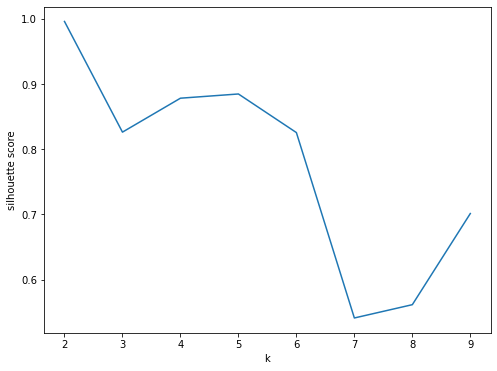

In [29]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("silhouette score")

## The optimal number of clusters (K) was chosen to be 4, and on this basis the data points in the dataset were assigned to the clusters.¶

In [20]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

# Trains a k-means model.
kmeans = KMeans(featuresCol='standardized').setK(4).setSeed(1)
model = kmeans.fit(data_scale_output)

# Make predictions
predictions = model.transform(data_scale_output)



Silhouette with squared euclidean distance = 0.8748819218948645


## The data in Spark is fetched back into the Python environment using "toPandas" conversion. 
This is done to then create visualisation on Python environment.

In [21]:
pandasDF=predictions.toPandas()

## Clustering results are visualised in a plot
- Cluster assignments: according to k-means
- Dataset: scaled data from above

In [23]:

x = [] # scaled data: feature "value"
y = [] # scaled data: feature "fee"
for i, j in pandasDF["standardized"].values:
    x.append(i)
    y.append(j)

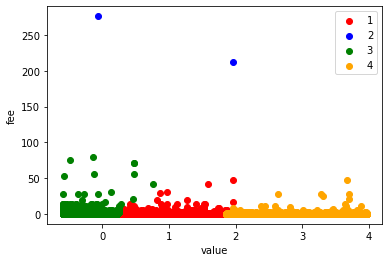

In [24]:
import matplotlib.pyplot as plt


import numpy as np
scatter_x = np.array(x) # scaled data: feature "value"
scatter_y = np.array(y) # scaled data: feature "fee"
group = np.array(pandasDF['prediction'])

cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange'}
fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g+1)
ax.legend()
plt.xlabel("value")
plt.ylabel("fee")
plt.show()

#plt.scatter(y=pandasDF["fee"],x=pandasDF["value"], c=pandasDF["prediction"], cmap='brg')
#plt.legend()

#plt.scatter(y=y,x=x, c=pandasDF["prediction"].values, cmap='brg')
#plt.legend()



## Boxplots are created
In the following, the data discussed are presented in boxplots in order to reveal new findings.
- For both features "value" and "fee" a boxplot is generated.
- Therein, for each of the 4 clusters a box is generated.

In [25]:
class1 = pandasDF.loc[pandasDF['prediction'] == 0]
class2 = pandasDF.loc[pandasDF['prediction'] == 1]
class3 = pandasDF.loc[pandasDF['prediction'] == 2]
class4 = pandasDF.loc[pandasDF['prediction'] == 3]

{'whiskers': [<matplotlib.lines.Line2D at 0x21970238370>,
 'caps': [<matplotlib.lines.Line2D at 0x219702636d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x219702231c0>,
 'medians': [<matplotlib.lines.Line2D at 0x219702a7490>,
 'fliers': [<matplotlib.lines.Line2D at 0x219702bd490>,
 'means': []}

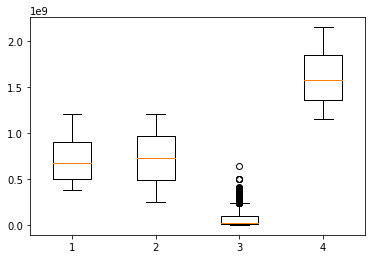

In [26]:
plt.boxplot([class1["value"], class2["value"], class3["value"], class4["value"]])

{'whiskers': [<matplotlib.lines.Line2D at 0x2197088ad60>,
 'caps': [<matplotlib.lines.Line2D at 0x219708aa520>,
 'boxes': [<matplotlib.lines.Line2D at 0x21970884cd0>,
 'medians': [<matplotlib.lines.Line2D at 0x219708bd250>,
 'fliers': [<matplotlib.lines.Line2D at 0x219708d2340>,
 'means': []}

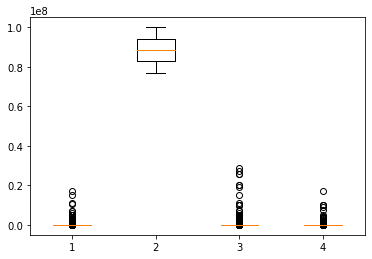

In [27]:
plt.boxplot([class1["fee"], class2["fee"], class3["fee"], class4["fee"]])